# CASO 4 - Radiohead (Creep) vs. The Hollies (the air that i breathe)

original: *The Air That I Breathe*, *The Hollies*

acusada: *Creep*, de Radiohead


A- MELODIA

Alegação: Foco na ponte para o refrão: melodia vocal e progressão harmônica

## Carregamento .mp3

In [ ]:
from google.colab import files
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from librosa.sequence import dtw
import librosa.util
from scipy.signal import resample



In [ ]:
print("Faça upload de dois arquivos .mp3 (original e acusado):")
uploaded = files.upload()


file_names = list(uploaded.keys())
if len(file_names) != 2:
    raise ValueError("Você deve carregar exatamente dois arquivos.")


Faça upload de dois arquivos .mp3 (original e acusado):


Saving Creep.mp3 to Creep.mp3
Saving The Air That I Breathe.mp3 to The Air That I Breathe.mp3


In [ ]:
print("\nArquivos enviados:")
for i, name in enumerate(file_names):
    print(f"{i+1}: {name}")

print("\nDigite exatamente o nome do arquivo que corresponde à OBRA ORIGINAL:")
nome_original = input().strip()

if nome_original not in file_names:
    raise ValueError("Nome inválido! Certifique-se de digitar exatamente como aparece acima.")

file_original = nome_original
file_acusado = [f for f in file_names if f != nome_original][0]
print(f"\nEntão o acusado é:\n{file_acusado}")


Arquivos enviados:
1: Creep.mp3
2: The Air That I Breathe.mp3

Digite exatamente o nome do arquivo que corresponde à OBRA ORIGINAL:
The Air That I Breathe.mp3

Então o acusado é:
Creep.mp3


# Cromagramas

In [ ]:
y_orig, sr_orig = librosa.load(file_original, sr=None)
y_acus, sr_acus = librosa.load(file_acusado, sr=None)


chroma_orig = librosa.feature.chroma_cqt(y=y_orig, sr=sr_orig)
chroma_acus = librosa.feature.chroma_cqt(y=y_acus, sr=sr_acus)

In [ ]:
'''
      The Air That I Breathe – The Hollies

Ponte para o refrão:
O trecho ocorre logo após o primeiro verso (por volta de 0:35), com a progressão harmônica:
F → E → Dm → C



      Creep – Radiohead

Ponte correspondente:
o trecho análogo ocorre antes do refrão explosivo: por volta de 0:58

A progressão harmônica aqui é quase idêntica:
G → B → C → Cm
'''

# extrair trecho especifico (em segundos)
def recorte(y, sr, inicio, fim):
    return y[int(inicio * sr):int(fim * sr)]

# recorte da ponte: ajuste os tempos
trecho_orig = recorte(y_orig, sr_orig, 35, 50)
trecho_acc = recorte(y_acus, sr_acus, 58, 73)

# extrair cromagrama (harmonia) e pitch (melodia)
c_orig = librosa.feature.chroma_cqt(y=trecho_orig, sr=sr_orig)
c_acc = librosa.feature.chroma_cqt(y=trecho_acc, sr=sr_acus)

In [ ]:
# imprimir cromagramas lado a lado

def plot_cromagramas_lado_a_lado(chroma1, chroma2, sr1, sr2, title1, title2, suptitle):
    fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    fig.suptitle(suptitle, fontsize=16)

    # cromagrama 1
    img1 = librosa.display.specshow(chroma1, y_axis='chroma', x_axis='time', sr=sr1, ax=axs[0])
    axs[0].set_title(title1)
    fig.colorbar(img1, ax=axs[0])

    # cromagrama 2
    img2 = librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time', sr=sr2, ax=axs[1])
    axs[1].set_title(title2)
    fig.colorbar(img2, ax=axs[1])

    # espaço para o titulo
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


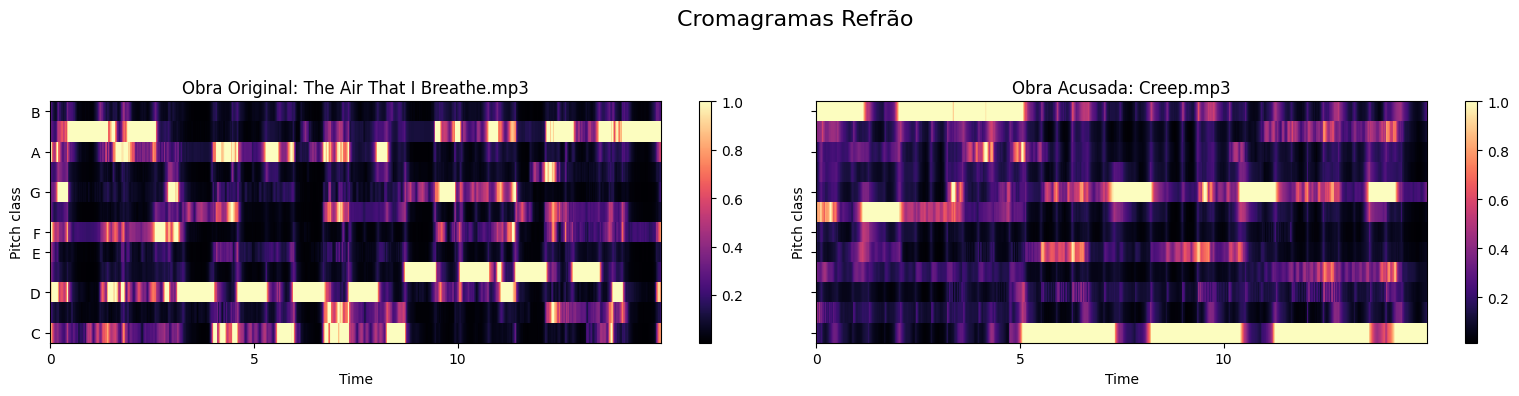

In [ ]:
plot_cromagramas_lado_a_lado(
    c_orig, c_acc,
    sr_orig, sr_acus,
    f'Obra Original: {file_original}',
    f'Obra Acusada: {file_acusado}',
    'Cromagramas Refrão'
)

## 1.Compressao Logaritmica - Sincronização

A compressão logarítmica ajuda a reduzir a variação de intensidade entre os vetores cromáticos antes de comparar

Redução de picos extremos, mais equilíbrio na visualização

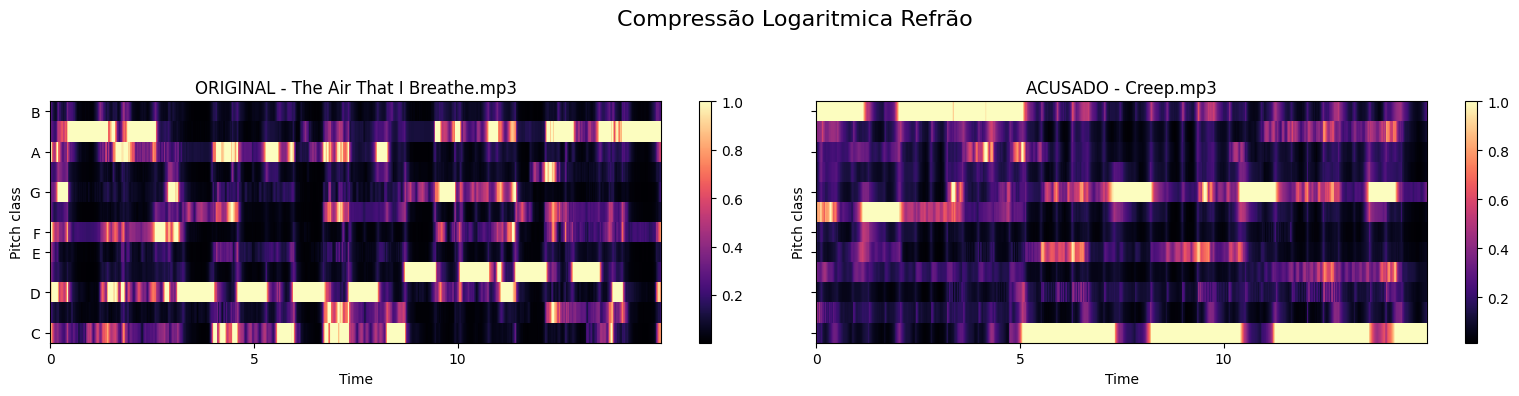

In [ ]:
def log_compression(S, factor=10000):
    return np.log1p(factor * S)

chroma_orig_log = log_compression(c_orig)
chroma_acus_log = log_compression(c_acc)


plot_cromagramas_lado_a_lado(
    c_orig, c_acc,
    sr_orig, sr_acus,
    f'ORIGINAL - {file_original}',
    f'ACUSADO - {file_acusado}',
    'Compressão Logaritmica Refrão'
)



## 2. Transposição para a tônica C - Sincronização

Transpor os cromagramas de ambas as músicas para que comecem na mesma tônica evita distorções na similaridade melódica



As “faixas” melódicas mudam de lugar, mas mantém a forma do contorno

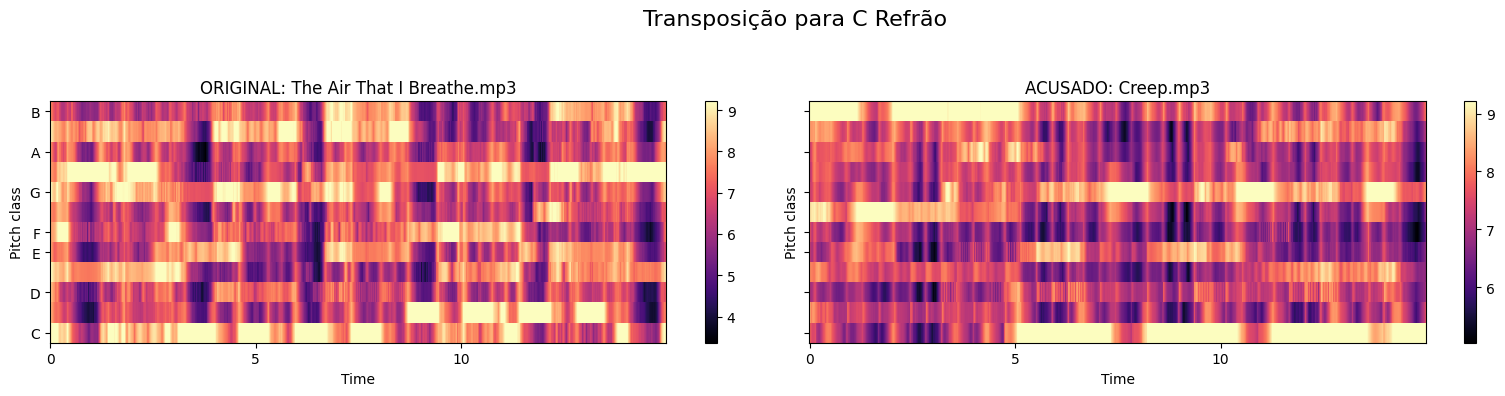

In [ ]:
def transpose_to_C(chroma):
    mean_vector = chroma.mean(axis=1)
    shift = np.argmax(mean_vector)
    return np.roll(chroma, -shift, axis=0)

chroma_orig_transposed = transpose_to_C(chroma_orig_log)
chroma_acus_transposed = transpose_to_C(chroma_acus_log)

plot_cromagramas_lado_a_lado(
    chroma_orig_transposed, chroma_acus_transposed,
    sr_orig, sr_acus,
    f'ORIGINAL: {file_original}',
    f'ACUSADO: {file_acusado}',
    'Transposição para C Refrão'
)


## 3.  Sincronização com DTW

Usar o Dynamic Time Warping com métrica de similaridade (cosseno) entre os cromagramas transpostos


Alinhamento visual, custo final e variação temporal

In [ ]:
chroma_orig_transposed = librosa.util.normalize(chroma_orig.T).T
chroma_acus_transposed = librosa.util.normalize(chroma_acus.T).T


In [ ]:
# reduzir dados para 1000 frames
target_frames = 1000

chroma_orig_ds = resample(chroma_orig_transposed, target_frames, axis=1)
chroma_acus_ds = resample(chroma_acus_transposed, target_frames, axis=1)

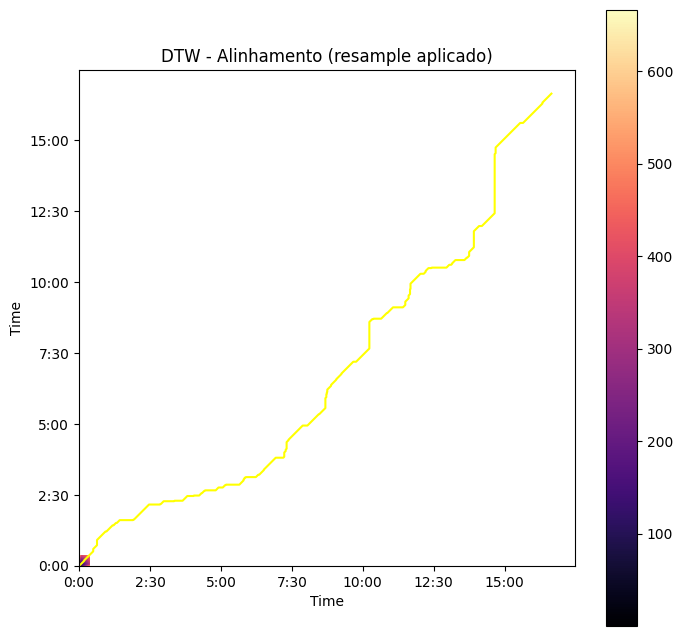

Distância DTW total: 0.50


In [ ]:
D, wp = dtw(X=chroma_orig_ds, Y=chroma_acus_ds, metric='cosine')

plt.figure(figsize=(8, 8))
librosa.display.specshow(D, x_axis='time', y_axis='time')
plt.plot(wp[:, 1], wp[:, 0], color='yellow')
plt.title('DTW - Alinhamento (resample aplicado)')
plt.colorbar()
plt.show()

dist_total = D[wp[-1, 0], wp[-1, 1]]
print(f"Distância DTW total: {dist_total:.2f}")


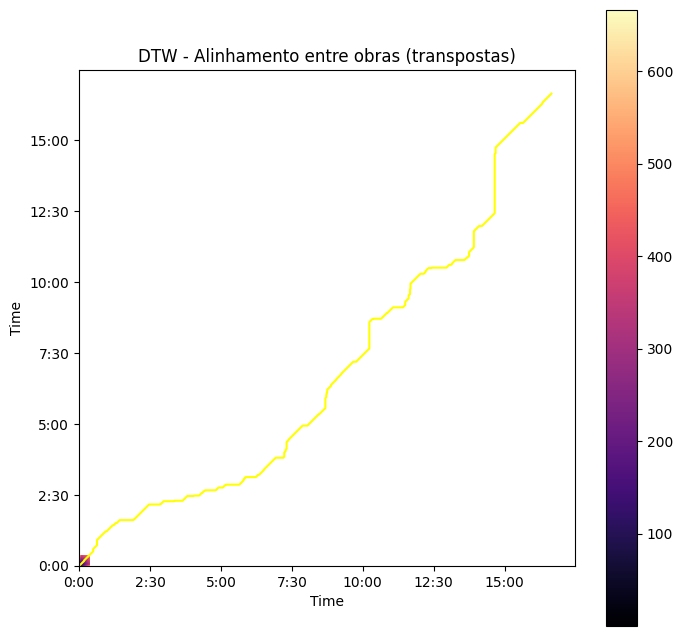

Distância DTW total (quanto menor, mais similar): 0.50


In [ ]:
# DTW com cosseno
D, wp = dtw(X=chroma_orig_ds, Y=chroma_acus_ds, metric='cosine')

plt.figure(figsize=(8, 8))
librosa.display.specshow(D, x_axis='time', y_axis='time')
plt.plot(wp[:, 1], wp[:, 0], color='yellow')
plt.title('DTW - Alinhamento entre refrões')
plt.colorbar()
plt.show()


dist_total = D[wp[-1, 0], wp[-1, 1]]
print(f"Distância DTW total (quanto menor, mais similar): {dist_total:.2f}")


In [ ]:
D_test, wp_test = dtw(X=chroma_orig_ds[:, :100], Y=chroma_acus_ds[:, :100], metric='cosine')
print("Distância DTW parcial (100 frames):", D_test[wp_test[-1, 0], wp_test[-1, 1]])


Distância DTW parcial (100 frames): 0.49696339959116287


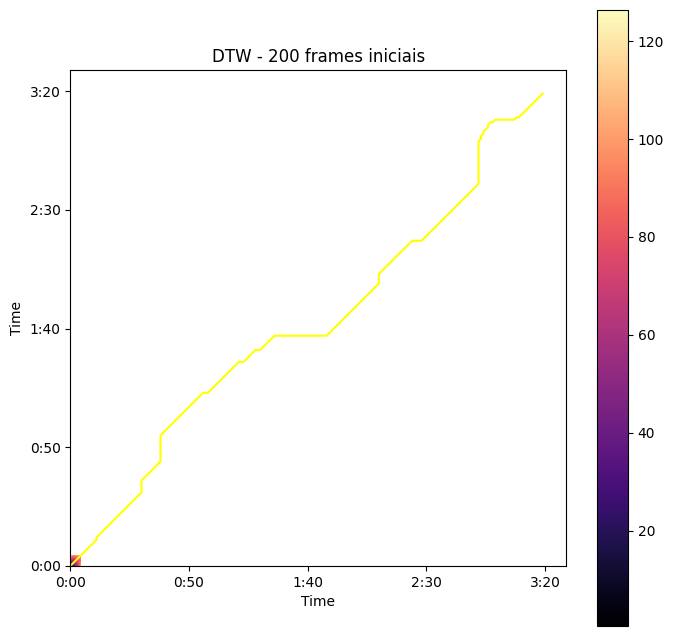

Distância DTW (200 frames): 0.4970


In [ ]:
# ajuste o tamanho
segmento = 200  # ou 300, 500 etc.

D_seg, wp_seg = dtw(X=chroma_orig_ds[:, :segmento], Y=chroma_acus_ds[:, :segmento], metric='cosine')
plt.figure(figsize=(8, 8))
librosa.display.specshow(D_seg, x_axis='time', y_axis='time')
plt.plot(wp_seg[:, 1], wp_seg[:, 0], color='yellow')
plt.title(f'DTW - {segmento} frames iniciais')
plt.colorbar()
plt.show()

print(f"Distância DTW ({segmento} frames): {D_seg[wp_seg[-1, 0], wp_seg[-1, 1]]:.4f}")
